In [10]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALSModel
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler 
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, FloatType, DoubleType
from pyspark.ml.linalg import Vectors, VectorUDT
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load data

In [2]:
spark = SparkSession.builder.appName("Recommendation").getOrCreate()

24/01/11 00:15:48 WARN Utils: Your hostname, QuangHieu resolves to a loopback address: 127.0.1.1; using 192.168.1.5 instead (on interface wlp1s0)
24/01/11 00:15:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/11 00:15:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/11 00:15:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
df = spark.read.parquet("./data/user_factor.parquet")
df.show(10)

+------+--------------------+
|    id|            features|
+------+--------------------+
|  4385|[0.32178158, 0.27...|
|  6575|[0.025274688, 0.1...|
| 16795|[0.11327801, 0.22...|
| 26535|[0.12633806, -0.0...|
| 30735|[0.05693576, 0.53...|
| 31315|[0.16496085, -0.0...|
| 68555|[0.362837, 0.1116...|
| 70415|[0.13669929, 0.24...|
|114865|[-0.10869225, 0.3...|
|120565|[0.13364035, -0.1...|
+------+--------------------+
only showing top 10 rows



In [4]:
to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Apply the UDF to create a new Vector column
df = df.withColumn("features_", to_vector_udf(col("features"))).select("id", "features_")

In [5]:
df.show(10)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+------+--------------------+
|    id|           features_|
+------+--------------------+
|  4385|[0.32178157567977...|
|  6575|[0.02527468837797...|
| 16795|[0.11327800899744...|
| 26535|[0.12633806467056...|
| 30735|[0.05693576112389...|
| 31315|[0.16496084630489...|
| 68555|[0.36283698678016...|
| 70415|[0.13669928908348...|
|114865|[-0.1086922511458...|
|120565|[0.13364034891128...|
+------+--------------------+
only showing top 10 rows



In [6]:
scaler = StandardScaler(inputCol="features_",  
                        outputCol="scaledFeatures",  
                        withStd=True,  
                        withMean=False) 
  
# Compute summary statistics by fitting the StandardScaler 
scalerModel = scaler.fit(df) 
  
# Normalize each feature to have unit standard deviation. 
final_data = scalerModel.transform(df) 
  
final_data.select('scaledFeatures').show(5)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+--------------------+
|      scaledFeatures|
+--------------------+
|[1.76758260960306...|
|[0.13883672346892...|
|[0.62224892252250...|
|[0.69398928627543...|
|[0.31275457898578...|
+--------------------+
only showing top 5 rows



In [ ]:
silhouette_score=[] 
  
evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                featuresCol='scaledFeatures', 
                                metricName='silhouette',  
                                distanceMeasure='squaredEuclidean') 
for i in range(10, 30):  
    for j in range(2,10): 
        kmeans=KMeans(featuresCol='scaledFeatures', k=j, maxIter=i) 
        model=kmeans.fit(final_data) 
        predictions=model.transform(final_data) 
        score=evaluator.evaluate(predictions) 
        silhouette_score.append(round(score, 4)) 
        print('Silhouette Score for k = {} in iter {} is {}'.format(j, i, score))

Silhouette Score for k = 2 in iter 10 is 0.048031328609357916


Silhouette Score for k = 3 in iter 10 is 0.026292816631636084
Silhouette Score for k = 4 in iter 10 is 0.01465395412403048


Silhouette Score for k = 5 in iter 10 is 0.03143831612973334


Silhouette Score for k = 6 in iter 10 is 0.01902824745828778


Silhouette Score for k = 7 in iter 10 is -0.03970387820046531


Silhouette Score for k = 8 in iter 10 is 0.013199467914581311
Silhouette Score for k = 9 in iter 10 is 0.04515952600250357


Silhouette Score for k = 2 in iter 11 is 0.04727083248121616


Silhouette Score for k = 3 in iter 11 is 0.026292816631636084
Silhouette Score for k = 4 in iter 11 is 0.01465395412403048
Silhouette Score for k = 5 in iter 11 is 0.03143831612973334
Silhouette Score for k = 6 in iter 11 is 0.01902824745828778
Silhouette Score for k = 7 in iter 11 is -0.039562844799670836
Silhouette Score for k = 8 in iter 11 is 0.013199467914581311


Silhouette Score for k = 9 in iter 11 is 0.04515952600250357
Silhouette Score for k = 2 in iter 12 is 0.047628016287060676
Silhouette Score for k = 3 in iter 12 is 0.026292816631636084


Silhouette Score for k = 4 in iter 12 is 0.01465395412403048


Silhouette Score for k = 5 in iter 12 is 0.03143831612973334


Silhouette Score for k = 6 in iter 12 is 0.01902824745828778


Silhouette Score for k = 7 in iter 12 is -0.039562844799670836


Silhouette Score for k = 8 in iter 12 is 0.013199467914581311
Silhouette Score for k = 9 in iter 12 is 0.04515952600250357
Silhouette Score for k = 2 in iter 13 is 0.04765949561451126
Silhouette Score for k = 3 in iter 13 is 0.026292816631636084


Silhouette Score for k = 4 in iter 13 is 0.01465395412403048
Silhouette Score for k = 5 in iter 13 is 0.03143831612973334
Silhouette Score for k = 6 in iter 13 is 0.01902824745828778


Silhouette Score for k = 7 in iter 13 is -0.039562844799670836


Silhouette Score for k = 8 in iter 13 is 0.013199467914581311
Silhouette Score for k = 9 in iter 13 is 0.04515952600250357
Silhouette Score for k = 2 in iter 14 is 0.0474532471198584
Silhouette Score for k = 3 in iter 14 is 0.026292816631636084
Silhouette Score for k = 4 in iter 14 is 0.01465395412403048
Silhouette Score for k = 5 in iter 14 is 0.03143831612973334
Silhouette Score for k = 6 in iter 14 is 0.01902824745828778


Silhouette Score for k = 7 in iter 14 is -0.039562844799670836


Silhouette Score for k = 8 in iter 14 is 0.013199467914581311
Silhouette Score for k = 9 in iter 14 is 0.04515952600250357
Silhouette Score for k = 2 in iter 15 is 0.04767406531790924


Silhouette Score for k = 3 in iter 15 is 0.026292816631636084
Silhouette Score for k = 4 in iter 15 is 0.01465395412403048
Silhouette Score for k = 5 in iter 15 is 0.03143831612973334
Silhouette Score for k = 6 in iter 15 is 0.01902824745828778
Silhouette Score for k = 7 in iter 15 is -0.039562844799670836
Silhouette Score for k = 8 in iter 15 is 0.013199467914581311
Silhouette Score for k = 9 in iter 15 is 0.04515952600250357


Silhouette Score for k = 2 in iter 16 is 0.04789822436411594


Silhouette Score for k = 3 in iter 16 is 0.026292816631636084


Silhouette Score for k = 4 in iter 16 is 0.01465395412403048
Silhouette Score for k = 5 in iter 16 is 0.03143831612973334


Silhouette Score for k = 6 in iter 16 is 0.01902824745828778
Silhouette Score for k = 7 in iter 16 is -0.039562844799670836


Silhouette Score for k = 8 in iter 16 is 0.013199467914581311
Silhouette Score for k = 9 in iter 16 is 0.04515952600250357
Silhouette Score for k = 2 in iter 17 is 0.04789746880791782
Silhouette Score for k = 3 in iter 17 is 0.026292816631636084


Silhouette Score for k = 4 in iter 17 is 0.01465395412403048
Silhouette Score for k = 5 in iter 17 is 0.03143831612973334


Silhouette Score for k = 6 in iter 17 is 0.01902824745828778


Silhouette Score for k = 7 in iter 17 is -0.039562844799670836


Silhouette Score for k = 8 in iter 17 is 0.013199467914581311


Silhouette Score for k = 9 in iter 17 is 0.04515952600250357


Silhouette Score for k = 2 in iter 18 is 0.04836523628752493


Silhouette Score for k = 3 in iter 18 is 0.026292816631636084
Silhouette Score for k = 4 in iter 18 is 0.01465395412403048
Silhouette Score for k = 5 in iter 18 is 0.03143831612973334
Silhouette Score for k = 6 in iter 18 is 0.01902824745828778
Silhouette Score for k = 7 in iter 18 is -0.039562844799670836
Silhouette Score for k = 8 in iter 18 is 0.013199467914581311
Silhouette Score for k = 9 in iter 18 is 0.04515952600250357


Silhouette Score for k = 2 in iter 19 is 0.04829444186942481
Silhouette Score for k = 3 in iter 19 is 0.026292816631636084
Silhouette Score for k = 4 in iter 19 is 0.01465395412403048
Silhouette Score for k = 5 in iter 19 is 0.03143831612973334


Silhouette Score for k = 6 in iter 19 is 0.01902824745828778


Silhouette Score for k = 7 in iter 19 is -0.039562844799670836


Silhouette Score for k = 8 in iter 19 is 0.013199467914581311


Silhouette Score for k = 9 in iter 19 is 0.04515952600250357
Silhouette Score for k = 2 in iter 20 is 0.04829444186942481
Silhouette Score for k = 3 in iter 20 is 0.026292816631636084
Silhouette Score for k = 4 in iter 20 is 0.01465395412403048


Silhouette Score for k = 5 in iter 20 is 0.03143831612973334
Silhouette Score for k = 6 in iter 20 is 0.01902824745828778
Silhouette Score for k = 7 in iter 20 is -0.039562844799670836


Silhouette Score for k = 8 in iter 20 is 0.013199467914581311


Silhouette Score for k = 9 in iter 20 is 0.04515952600250357


Silhouette Score for k = 2 in iter 21 is 0.04829444186942481


Silhouette Score for k = 3 in iter 21 is 0.026292816631636084


Silhouette Score for k = 4 in iter 21 is 0.01465395412403048
Silhouette Score for k = 5 in iter 21 is 0.03143831612973334


Silhouette Score for k = 6 in iter 21 is 0.01902824745828778


Silhouette Score for k = 7 in iter 21 is -0.039562844799670836


Silhouette Score for k = 8 in iter 21 is 0.013199467914581311


Silhouette Score for k = 9 in iter 21 is 0.04515952600250357


Silhouette Score for k = 2 in iter 22 is 0.04829444186942481


Silhouette Score for k = 3 in iter 22 is 0.026292816631636084


Silhouette Score for k = 4 in iter 22 is 0.01465395412403048
Silhouette Score for k = 5 in iter 22 is 0.03143831612973334
Silhouette Score for k = 6 in iter 22 is 0.01902824745828778
Silhouette Score for k = 7 in iter 22 is -0.039562844799670836
Silhouette Score for k = 8 in iter 22 is 0.013199467914581311
Silhouette Score for k = 9 in iter 22 is 0.04515952600250357
Silhouette Score for k = 2 in iter 23 is 0.04829444186942481
Silhouette Score for k = 3 in iter 23 is 0.026292816631636084
Silhouette Score for k = 4 in iter 23 is 0.01465395412403048
Silhouette Score for k = 5 in iter 23 is 0.03143831612973334
Silhouette Score for k = 6 in iter 23 is 0.01902824745828778


Silhouette Score for k = 7 in iter 23 is -0.039562844799670836
Silhouette Score for k = 8 in iter 23 is 0.013199467914581311
Silhouette Score for k = 9 in iter 23 is 0.04515952600250357
Silhouette Score for k = 2 in iter 24 is 0.04829444186942481


Silhouette Score for k = 3 in iter 24 is 0.026292816631636084


Silhouette Score for k = 4 in iter 24 is 0.01465395412403048
Silhouette Score for k = 5 in iter 24 is 0.03143831612973334
Silhouette Score for k = 6 in iter 24 is 0.01902824745828778


Silhouette Score for k = 7 in iter 24 is -0.039562844799670836
Silhouette Score for k = 8 in iter 24 is 0.013199467914581311


Silhouette Score for k = 9 in iter 24 is 0.04515952600250357
Silhouette Score for k = 2 in iter 25 is 0.04829444186942481
Silhouette Score for k = 3 in iter 25 is 0.026292816631636084
Silhouette Score for k = 4 in iter 25 is 0.01465395412403048
Silhouette Score for k = 5 in iter 25 is 0.03143831612973334
Silhouette Score for k = 6 in iter 25 is 0.01902824745828778
Silhouette Score for k = 7 in iter 25 is -0.039562844799670836
Silhouette Score for k = 8 in iter 25 is 0.013199467914581311
Silhouette Score for k = 9 in iter 25 is 0.04515952600250357


Silhouette Score for k = 2 in iter 26 is 0.04829444186942481
Silhouette Score for k = 3 in iter 26 is 0.026292816631636084


Silhouette Score for k = 4 in iter 26 is 0.01465395412403048


Silhouette Score for k = 5 in iter 26 is 0.03143831612973334


Silhouette Score for k = 6 in iter 26 is 0.01902824745828778


Silhouette Score for k = 7 in iter 26 is -0.039562844799670836
Silhouette Score for k = 8 in iter 26 is 0.013199467914581311
Silhouette Score for k = 9 in iter 26 is 0.04515952600250357
Silhouette Score for k = 2 in iter 27 is 0.04829444186942481
Silhouette Score for k = 3 in iter 27 is 0.026292816631636084
Silhouette Score for k = 4 in iter 27 is 0.01465395412403048
Silhouette Score for k = 5 in iter 27 is 0.03143831612973334
Silhouette Score for k = 6 in iter 27 is 0.01902824745828778


Silhouette Score for k = 7 in iter 27 is -0.039562844799670836
Silhouette Score for k = 8 in iter 27 is 0.013199467914581311
Silhouette Score for k = 9 in iter 27 is 0.04515952600250357


Silhouette Score for k = 2 in iter 28 is 0.04829444186942481
Silhouette Score for k = 3 in iter 28 is 0.026292816631636084


Silhouette Score for k = 4 in iter 28 is 0.01465395412403048
Silhouette Score for k = 5 in iter 28 is 0.03143831612973334
Silhouette Score for k = 6 in iter 28 is 0.01902824745828778
Silhouette Score for k = 7 in iter 28 is -0.039562844799670836
Silhouette Score for k = 8 in iter 28 is 0.013199467914581311
Silhouette Score for k = 9 in iter 28 is 0.04515952600250357
Silhouette Score for k = 2 in iter 29 is 0.04829444186942481
Silhouette Score for k = 3 in iter 29 is 0.026292816631636084


Silhouette Score for k = 4 in iter 29 is 0.01465395412403048


Silhouette Score for k = 5 in iter 29 is 0.03143831612973334


Silhouette Score for k = 6 in iter 29 is 0.01902824745828778
Silhouette Score for k = 7 in iter 29 is -0.039562844799670836
Silhouette Score for k = 8 in iter 29 is 0.013199467914581311


Silhouette Score for k = 9 in iter 29 is 0.04515952600250357


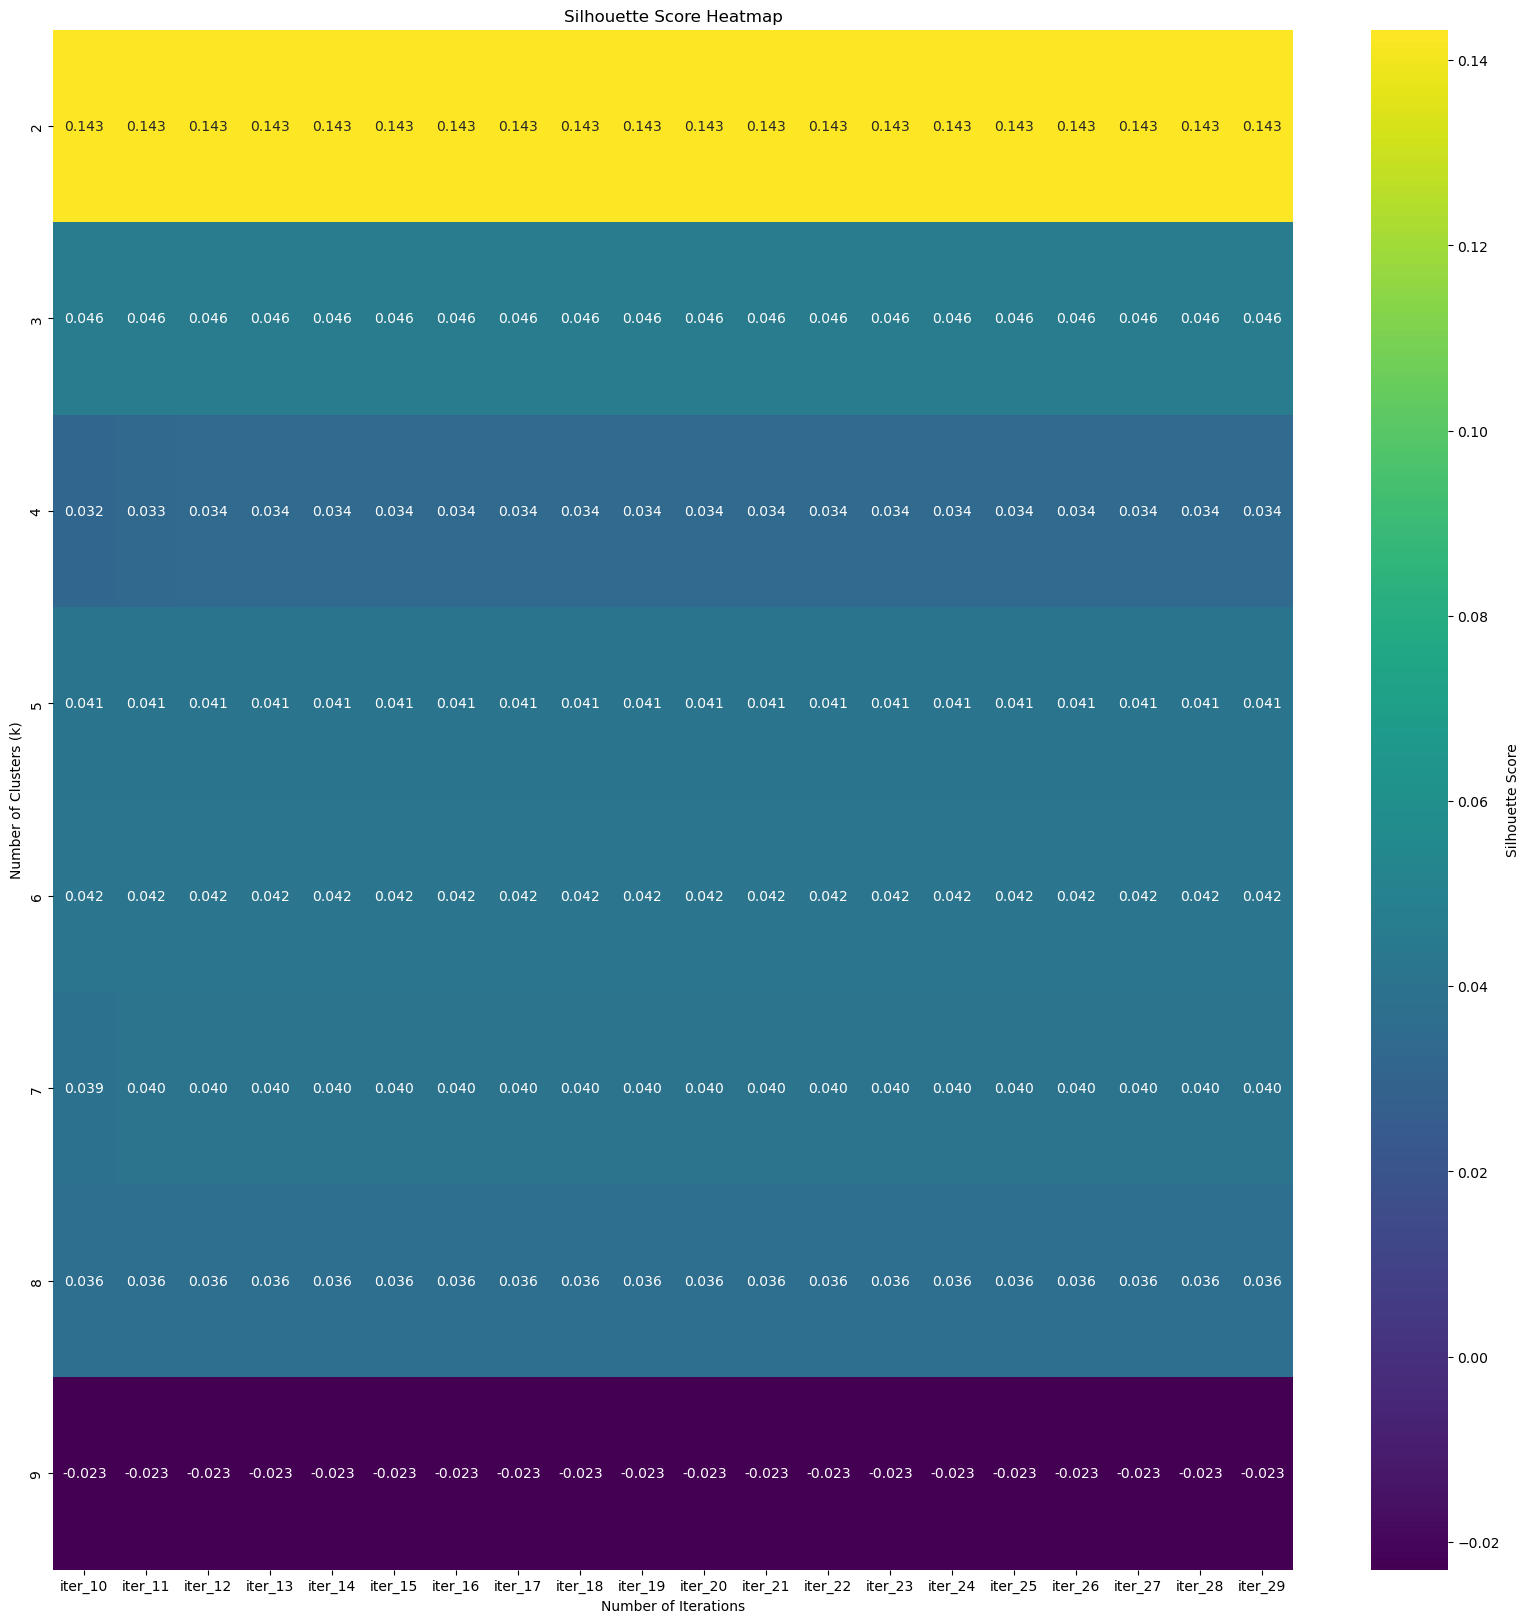

In [ ]:
k_values = range(2, 10)
iterations = range(10, 30)  
silhouette_scores = silhouette_score

# Convert silhouette scores to a DataFrame
scores = np.reshape(silhouette_scores, (len(iterations),len(k_values))) 
df = pd.DataFrame(np.array(scores).T, columns=[f'iter_{i}' for i in iterations], index=k_values)
plt.figure(figsize=(20, 20))
# Create a heatmap
sns.heatmap(df, annot=True, cmap='viridis', fmt='.3f', cbar_kws={'label': 'Silhouette Score'})
plt.xlabel('Number of Iterations')
plt.ylabel('Number of Clusters (k)')
plt.title('Silhouette Score Heatmap')
plt.show()

In [ ]:
max(silhouette_score)

0.1433

In [7]:
#--> 10 iters, 2 clusters
silhouette_score=[] 
  
evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                featuresCol='scaledFeatures', 
                                metricName='silhouette',  
                                distanceMeasure='squaredEuclidean') 
for i in range(2, 60):  
    kmeans=KMeans(featuresCol='scaledFeatures', k=i, maxIter=10) 
    model=kmeans.fit(final_data) 
    predictions=model.transform(final_data) 
    score=evaluator.evaluate(predictions) 
    silhouette_score.append(score) 
    #print('Silhouette Score for k = {} is {}'.format( i, score))

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

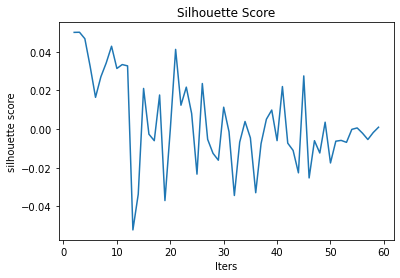

In [9]:
#Visualizing the silhouette scores in a plot 
import matplotlib.pyplot as plt 

plt.plot(range(2, 60),silhouette_score) 
plt.xlabel('Iters') 
plt.ylabel('silhouette score') 
plt.title('Silhouette Score') 
plt.show()
# 1 iter, 2 clusters

In [ ]:
# training cost: Sum of square distance to nearest centroid

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

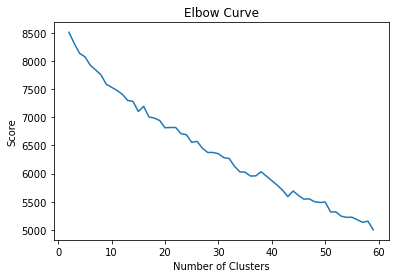

In [14]:
cluster = 60
cost = np.zeros(cluster)

for k in range(2,cluster):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('scaledFeatures')
    model = kmeans.fit(final_data)
    cost[k] = model.summary.trainingCost
    #K-means cost (sum of squared distances to the nearest centroid for all points in the training dataset).
    # This is equivalent to sklearn’s inertia.

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [i for i in range(2,cluster)]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
# Trains a k-means model.
kmeans = KMeans().setK(2).setFeaturesCol("scaledFeatures").setPredictionCol("prediction").setMaxIter(10)
model = kmeans.fit(final_data)

# Make predictions
predictions = model.transform(final_data)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                featuresCol='scaledFeatures', 
                                metricName='silhouette',  
                                distanceMeasure='squaredEuclidean')

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.048031328609357916
Cluster Centers: 
[ 0.46971899  0.86456763  0.91334973  1.18618401 -1.22474417  0.47005216
 -0.20329449  0.23113486 -0.63982002 -0.91682804 -0.43617785 -0.2286997
  0.47512157  0.55371068  0.21001932  0.47008855 -0.1523846  -0.35840311
  0.40377379 -0.47729184  0.08067265 -0.84788004  0.42979447 -1.07668807
 -0.45205462 -0.49119679  0.00473227 -0.17480191  1.22822386 -0.36879764
 -0.5242614  -0.05812981  0.20910693  0.79414401  0.2140571 ]
[ 0.54107104  0.83939588  0.81429479  1.13336    -0.68522992  0.5596427
  0.18777212 -0.01445317 -0.64446381 -0.57035303 -0.85268803  0.19444986
  0.50096596  0.64023101 -0.48197374  0.85292469 -0.06103338  0.00273672
  0.69375138 -0.12466753 -0.51340715 -0.36007879  0.22890115 -0.86660005
 -0.33686401 -0.71862414 -0.80807413 -0.29698267  1.92345425 -0.18043347
 -0.7674262   0.0375475  -0.17312087  0.57073113 -0.14165964]


In [ ]:
model.save('./model/kmeans_1')

In [ ]:
predictions.show()

+------+--------------------+--------------------+----------+
|    id|           features_|      scaledFeatures|prediction|
+------+--------------------+--------------------+----------+
|  4385|[0.32178157567977...|[1.76758260960306...|         0|
|  6575|[0.02527468837797...|[0.13883672346892...|         0|
| 16795|[0.11327800899744...|[0.62224892252250...|         0|
| 26535|[0.12633806467056...|[0.69398928627543...|         0|
| 30735|[0.05693576112389...|[0.31275457898578...|         0|
| 31315|[0.16496084630489...|[0.90614859653773...|         0|
| 68555|[0.36283698678016...|[1.99310462881079...|         1|
| 70415|[0.13669928908348...|[0.75090466450297...|         0|
|114865|[-0.1086922511458...|[-0.5970588356966...|         1|
|120565|[0.13364034891128...|[0.73410155997231...|         1|
|128835|[0.31945481896400...|[1.75480147165602...|         0|
|135265|[0.39165353775024...|[2.15139720431281...|         0|
|143175|[0.22253327071666...|[1.22240043901180...|         1|
|158295|

In [ ]:
def compute_distance(row):
    cluster_id = row['prediction']
    user_feature = row['scaledFeatures']
    if cluster_id == 0:
        euclidean_distance = np.linalg.norm(user_feature - centers[0])
    if cluster_id == 1:
        euclidean_distance = np.linalg.norm(user_feature - centers[1])
    return euclidean_distance

In [ ]:
predictions = predictions.toPandas()
predictions.head(3)

,id,features_,scaledFeatures,prediction
0,4385,"[0.32178157567977905, 0.27567291259765625, 0.0...","[1.7675826096030647, 1.4224833123692373, 0.373...",0
1,6575,"[0.025274688377976418, 0.1411098688840866, 0.0...","[0.138836723468923, 0.7281325967313441, 0.0470...",0
2,16795,"[0.11327800899744034, 0.2236904501914978, 0.16...","[0.6222489225225007, 1.1542517164106496, 0.899...",0


In [ ]:
predictions['distance_to_centroid'] = predictions.apply(compute_distance, axis=1)

In [ ]:
predictions.head(3)

,id,features_,scaledFeatures,prediction,distance_to_centroid
0,4385,"[0.32178157567977905, 0.27567291259765625, 0.0...","[1.7675826096030647, 1.4224833123692373, 0.373...",0,4.875994
1,6575,"[0.025274688377976418, 0.1411098688840866, 0.0...","[0.138836723468923, 0.7281325967313441, 0.0470...",0,5.839899
2,16795,"[0.11327800899744034, 0.2236904501914978, 0.16...","[0.6222489225225007, 1.1542517164106496, 0.899...",0,5.713727


In [ ]:
import pandas as pd

In [ ]:
ratings = pd.read_csv("./data/cleaned_ratings.csv")

In [ ]:
ratings.rename(columns={"user_id":"id"}, inplace=True)
ratings.head(3)

,Unnamed: 0,id,ISBN,rating
0,14854,2276,0020960808,10
1,14856,2276,0030632366,9
2,14858,2276,0061030643,8


In [ ]:
result_df = pd.merge(predictions, ratings, on='id', how='inner')
result_df = result_df[["id", "scaledFeatures", "prediction", "distance_to_centroid", "ISBN", "rating"]]

In [ ]:
result_df.head(3)

,id,scaledFeatures,prediction,distance_to_centroid,ISBN,rating
0,4385,"[1.7675826096030647, 1.4224833123692373, 0.373...",0,4.875994,0061083402,10
1,4385,"[1.7675826096030647, 1.4224833123692373, 0.373...",0,4.875994,0061093343,9
2,4385,"[1.7675826096030647, 1.4224833123692373, 0.373...",0,4.875994,0061096156,10


In [ ]:
cluster_0 = result_df[result_df['prediction'] == 0]
cluster_1 = result_df[result_df['prediction'] == 1]

In [ ]:
cluster_0.head(3)

,id,scaledFeatures,prediction,distance_to_centroid,ISBN,rating
0,4385,"[1.7675826096030647, 1.4224833123692373, 0.373...",0,4.875994,0061083402,10
1,4385,"[1.7675826096030647, 1.4224833123692373, 0.373...",0,4.875994,0061093343,9
2,4385,"[1.7675826096030647, 1.4224833123692373, 0.373...",0,4.875994,0061096156,10


In [ ]:
cluster_0.shape

(64270, 6)

In [ ]:
cluster_1.head(3)

,id,scaledFeatures,prediction,distance_to_centroid,ISBN,rating
2130,68555,"[1.9931046288107976, 0.5758678896935929, 2.557...",1,6.065333,000712032X,9
2131,68555,"[1.9931046288107976, 0.5758678896935929, 2.557...",1,6.065333,0007154615,3
2132,68555,"[1.9931046288107976, 0.5758678896935929, 2.557...",1,6.065333,0028626354,8


In [ ]:
cluster_1.shape

(23542, 6)

## Cluster 0

In [ ]:
# Sort and get top 20 users
cluster_0 = cluster_0.sort_values(by="distance_to_centroid", ascending=True)
top_20_0 = cluster_0['id'].unique()[:20]
top_20_c0 = cluster_0[cluster_0['id'].isin(top_20_0)].drop_duplicates(subset='id')
top_20_c0.head()

,id,scaledFeatures,prediction,distance_to_centroid,ISBN,rating
0,4385,"[1.7675826096030647, 1.4224833123692373, 0.373...",0,4.875994,0061083402,10
33907,229329,"[-0.5440735432018002, 0.13319762821121114, 2.1...",0,4.896681,0553273604,7
17029,222204,"[-0.7973219699892337, 0.03278572264075934, 1.3...",0,4.920707,0441157513,9
73552,236948,"[-0.6385404819505033, 1.7484683538083396, -0.7...",0,5.026445,0132369281,9
27875,56399,"[-0.2526646252739602, 1.7992592025054828, -0.1...",0,5.034262,0803269072,10


In [ ]:
## Calculate avg rating 
avg_ratings_by_isbn_c0 = top_20_c0.groupby('ISBN')['rating'].mean().reset_index()
avg_ratings_by_isbn_c0.head()

,ISBN,rating
0,0061083402,10.0
1,0132369281,9.0
2,0373790864,10.0
3,0375709150,7.0
4,0380973820,8.0


In [ ]:
avg_ratings_by_isbn_c0.shape

(20, 2)

## Cluster 1

In [ ]:
# Sort and get top 20 users in cluster 1
cluster_1 = cluster_1.sort_values(by="distance_to_centroid", ascending=True)
top_20_1 = cluster_1['id'].unique()[:20]
top_20_c1 = cluster_1[cluster_1['id'].isin(top_20_1)].drop_duplicates(subset='id')
top_20_c1.head()

,id,scaledFeatures,prediction,distance_to_centroid,ISBN,rating
87640,241980,"[0.7809184755379671, 1.8647655262622067, 2.807...",1,4.839763,1579541186,7
18623,257204,"[0.32738360659842114, 0.9096101537272882, 1.21...",1,5.106396,0812555104,10
21649,94853,"[1.4410032776334087, -0.0867997215849373, -0.1...",1,5.114778,0201094444,10
20804,78973,"[-0.666471401161374, 0.1830047579115651, 0.542...",1,5.156543,0749719095,9
21422,88733,"[0.6559220470364914, 1.0296273698574547, 1.627...",1,5.174555,0684850613,9


In [ ]:
## Calculate avg rating 
avg_ratings_by_isbn_c1 = top_20_c1.groupby('ISBN')['rating'].mean().reset_index()
avg_ratings_by_isbn_c1.head()

,ISBN,rating
0,0061000043,8.0
1,0201094444,10.0
2,0345413865,8.0
3,0373226144,9.0
4,0380973650,7.0


In [ ]:
avg_ratings_by_isbn_c1.shape

(15, 2)

## Example recommend for user 4385

In [ ]:
# Check cluster of 4385
is_present = cluster_0['id'].isin([4385]).any()
is_present

True

In [ ]:
is_present = cluster_1['id'].isin([4385]).any()
is_present

False

In [ ]:
## Get all book user 4385 has rated
books_rated_by_4385 = ratings[ratings['id'] == 4385]
books_rated_by_4385.shape

(213, 4)

In [ ]:
books_rated_by_4385['ISBN'].values

array(['0061083402', '0061093343', '0061096156', '0312956762',
       '0312980353', '0345446100', '0373024665', '0373025920',
       '0373032072', '0373035101', '0373051921', '0373072422',
       '0373074123', '0373074492', '0373074808', '0373075286',
       '0373076223', '0373076371', '0373076592', '0373076746',
       '0373076932', '0373077289', '0373078056', '0373088701',
       '0373092741', '0373093799', '0373093829', '0373095244',
       '0373096585', '0373096828', '0373097840', '0373098006',
       '0373098677', '0373098847', '0373098855', '0373098987',
       '0373099150', '0373099169', '0373099568', '037310507X',
       '0373105401', '037310667X', '0373106734', '0373107072',
       '0373109040', '0373111622', '0373114931', '0373115458',
       '0373116373', '0373117949', '0373118651', '0373118716',
       '0373121369', '0373151896', '0373160011', '0373161387',
       '0373162111', '0373162227', '0373164386', '0373165048',
       '0373165544', '0373165595', '0373165811', '03731

In [ ]:
recommend = avg_ratings_by_isbn_c1[~avg_ratings_by_isbn_c1["ISBN"].isin(books_rated_by_4385['ISBN'].values)]

In [ ]:
recommend.shape

(15, 2)

In [ ]:
def recommend(user_id, cluster_0, cluster_1):
    is_present_0 = cluster_0['id'].isin([user_id]).any()
    is_present_1 = cluster_1['id'].isin([user_id]).any()
    if is_present_0:
        ## Get all book user 4385 has rated
        books_rated_by_user = ratings[ratings['id'] == user_id]
        recommend = avg_ratings_by_isbn_c0[~avg_ratings_by_isbn_c0["ISBN"].isin(books_rated_by_user['ISBN'].values)]
        print("0")
    if is_present_1:
        books_rated_by_user = ratings[ratings['id'] == user_id]
        recommend = avg_ratings_by_isbn_c1[~avg_ratings_by_isbn_c1["ISBN"].isin(books_rated_by_user['ISBN'].values)]    
        print("1")
    return recommend['ISBN'].values

In [ ]:
recommend(56399, cluster_0, cluster_1)

0


array(['0006174760', '0064431037', '0140707247', '0345423291',
       '037540421X', '0385314280', '0385335466', '038549744X',
       '0439164842', '0440224071', '0441135560', '0486400611',
       '0553268929', '0582067227', '0609810022', '0679446486',
       '0747504687', '0836210263', '1559583126', '1895897572'],
      dtype=object)

In [ ]:
cluster_0.to_csv('./data/cluster_0.csv')
cluster_1.to_csv('./data/cluster_1.csv')

In [ ]:
## Calculate avg rating 
avg_ratings_by_isbn_c0 = cluster_0.groupby('ISBN')['rating'].mean().reset_index()
ratings_in_cluster_0 = avg_ratings_by_isbn_c0.sort_values(by='rating', ascending=False)
ratings_in_cluster_0.head(3)

,ISBN,rating
14061,0373441320,10.0
14609,0373711239,10.0
40732,0753100185,10.0


In [ ]:
## Calculate avg rating 
avg_ratings_by_isbn_c1 = cluster_1.groupby('ISBN')['rating'].mean().reset_index()
ratings_in_cluster_1 = avg_ratings_by_isbn_c1.sort_values(by='rating', ascending=False)
ratings_in_cluster_1.head(3)

,ISBN,rating
715,0373123108,10.0
1882,0671744623,10.0
507,0345384385,10.0


In [ ]:
ratings_in_cluster_0.to_csv('./data/top_ratings_cluster_0.csv')
ratings_in_cluster_1.to_csv('./data/top_ratings_cluster_1.csv')


In [ ]:
r0 = pd.read_csv('./data/top_ratings_cluster_0.csv')
r0.head(3)

,Unnamed: 0,ISBN,rating
0,14061,0373441320,10.0
1,14609,0373711239,10.0
2,40732,0753100185,10.0
